In [1]:
import numpy as np
import matplotlib.pyplot as plt
from A2C.a2c_vec_env import A2C
import torch
import networkx as nx
import gym_LTTD_v0
import gymnasium as gym
from tqdm import tqdm
import pickle

# Training

In [2]:
def train(
        n_updates:int,
        n_steps_per_update:int,
        n_envs:int,
        device:str,
        envs_wrapper:gym.Wrapper,
        agent:A2C,
        critic_losses:list,
        actor_losses:list,
        entropies:list,
        gamma:float=0.6,
        lam:float=0.95,
        ent_coef:float=0.01
        ):
    # use tqdm to get a progress bar for training
    for sample_phase in tqdm(range(1,n_updates+1)):
        # we don't have to reset the envs, they just continue playing
        # until the episode is over and then reset automatically

        # reset lists that collect experiences of an episode (sample phase)
        ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_action_log_probs = torch.zeros(
            n_steps_per_update, n_envs, device=device)
        masks = torch.zeros(n_steps_per_update, n_envs, device=device)

        # at the start of training reset all envs to get an initial state
        if sample_phase == 1:
            states, info = envs_wrapper.reset()

        nodeState = list(map(lambda _: set(), range(n_envs)))
        # candidate_nodes = list(map(lambda _:set(),range(n_envs)))

        # play n steps in our parallel environments to collect data
        for step in range(n_steps_per_update):
            # select an action A_{t} using S_{t} as input for the agent
            for i in range(n_envs):
                nodeState[i] = (info['T_active'][i] | info['R_active'][i])
   
            states = torch.tensor(states, dtype=torch.float32, device=device)
            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                states, nodeState
            )

            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            actions = actions.cpu().numpy()
            states, rewards, terminated, _, info = envs_wrapper.step(actions)

            ep_value_preds[step] = torch.squeeze(state_value_preds)
            ep_rewards[step] = torch.tensor(rewards, device=device)
            ep_action_log_probs[step] = action_log_probs

            # add a mask (for the return calculation later);
            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor([not term for term in terminated])
            for i,term in enumerate(terminated):
                if term:
                    nodeState[i].clear()

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            ep_rewards,
            ep_action_log_probs,
            ep_value_preds,
            entropy,
            masks,
            gamma,
            lam,
            ent_coef,
            device,
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)

        # log the losses and entropy
        # TR_score.append(TR_rate/terminated_num)
        critic_losses.append(critic_loss.detach().cpu().numpy())
        actor_losses.append(actor_loss.detach().cpu().numpy())
        entropies.append(entropy.detach().mean().cpu().numpy())
        # if(sample_phase%100==0):
        #     print(f'episode: {sample_phase}, avg TR rate: {np.mean(np.array(TR_score))}')


# plot

In [3]:
def plot_results(envs_wrapper:gym.Wrapper,actor_losses:list,critic_losses:list,entropies:list,rolling_length:int=100,save_name:str=None):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    # episode return
    axs[0][0].set_title("Episode Returns")
    episode_returns_moving_average = (
        np.convolve(
            np.array(envs_wrapper.return_queue),
            np.ones(rolling_length),
            mode="valid",
        )
        / rolling_length
    )
    axs[0][0].plot(
        episode_returns_moving_average
    )
    axs[0][0].set_xlabel("Number of episodes")

    # entropy
    axs[1][0].set_title("Entropy")
    entropy_moving_average = (
        np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1][0].plot(entropy_moving_average)
    axs[1][0].set_xlabel("Number of updates")


    # critic loss
    axs[0][1].set_title("Critic Loss")
    critic_losses_moving_average = (
        np.convolve(
            np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0][1].plot(critic_losses_moving_average)
    axs[0][1].set_xlabel("Number of updates")


    # actor loss
    axs[1][1].set_title("Actor Loss")
    actor_losses_moving_average = (
        np.convolve(np.array(actor_losses).flatten(),
                    np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1][1].plot(actor_losses_moving_average)
    axs[1][1].set_xlabel("Number of updates")

    # plt.tight_layout()
    if save_name is not None:
        plt.savefig(f'../result_img/{save_name}.jpg',dpi=250,bbox_inches='tight')
    plt.show()

# Dolphin

In [4]:
G1 = nx.read_adjlist('../dataset/dolphins.mtx', nodetype=int)

In [5]:
gamma = 0.6
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
n_envs = 4
n_updates = 1000
n_steps_per_update = 128

In [7]:
dol_env = gym.vector.AsyncVectorEnv(
    [
        lambda:gym.make(
            'LTTD-v0',
            G=G1,
            init_rumor_rate=0.1,
            au_T_rate=0.08,
            k_budget=0.1,
            alpha=-1,
            target_to_reach=0.155,
            R_score_base=1.3
        ),
        lambda:gym.make(
            'LTTD-v0',
            G=G1,
            init_rumor_rate=0.1,
            au_T_rate=0.08,
            k_budget=0.150,
            alpha=-1,
            target_to_reach=0.147,
            R_score_base=1.3
        ),
        lambda:gym.make(
            'LTTD-v0',
            G=G1,
            init_rumor_rate=0.1,
            au_T_rate=0.08,
            k_budget=0.20,
            alpha=-1,
            target_to_reach=0.141,
            R_score_base=1.3
        ),
        lambda:gym.make(
            'LTTD-v0',
            G=G1,
            init_rumor_rate=0.1,
            au_T_rate=0.08,
            k_budget=0.25,
            alpha=-1,
            target_to_reach=0.137,
            R_score_base=1.3
        ),
    ]
)
obs_shape = dol_env.single_action_space.n
action_shape = dol_env.single_action_space.n

In [8]:
critic_losses = []
actor_losses = []
entropies = []

In [9]:
dol_agent = A2C(G1, obs_shape, action_shape,64,64,device, critic_lr, actor_lr, n_envs)

In [12]:
dol_agent.actor.load_state_dict(torch.load('../model_weight/dolphin_a2c_v0_3.pkl'))
dol_agent.critic.load_state_dict(torch.load('../model_weight/dolphin_a2c_critic_v0_3.pkl'))

<All keys matched successfully>

In [10]:
dol_envs_wrapper = gym.wrappers.RecordEpisodeStatistics(
    dol_env, deque_size=1_000_000)

100%|██████████| 1000/1000 [25:45<00:00,  1.55s/it]


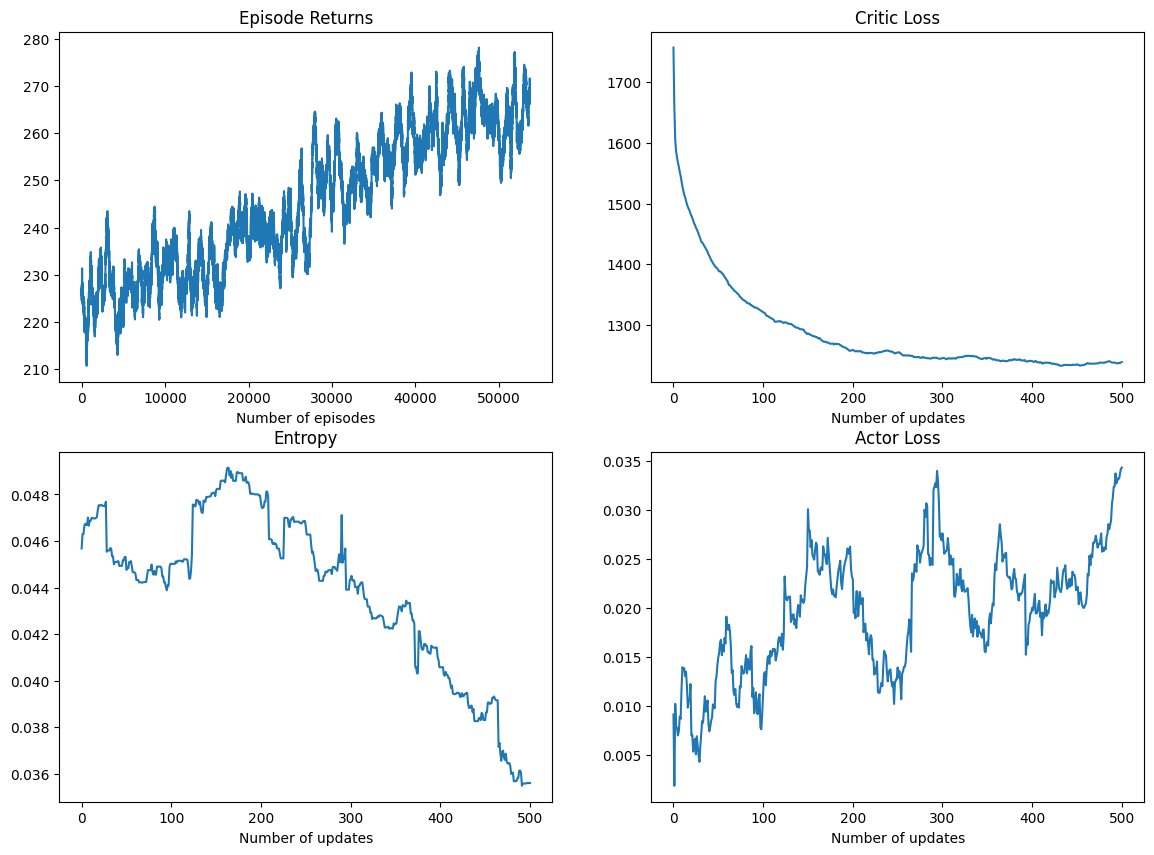

In [11]:
train(n_updates,n_steps_per_update,n_envs,device,dol_envs_wrapper,dol_agent,critic_losses,actor_losses,entropies,gamma,lam)
plot_results(dol_envs_wrapper,actor_losses,critic_losses,entropies,500,)

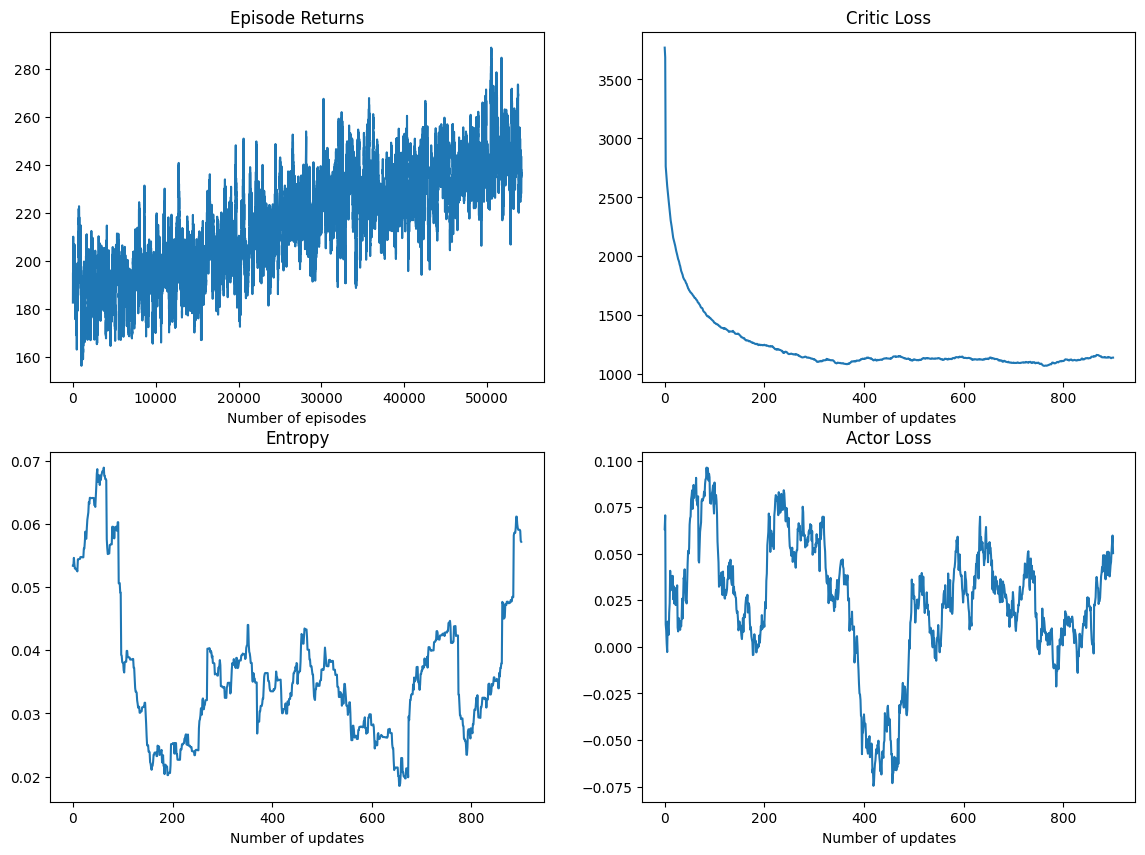

In [12]:
plot_results(dol_envs_wrapper,actor_losses,critic_losses,entropies,100,)

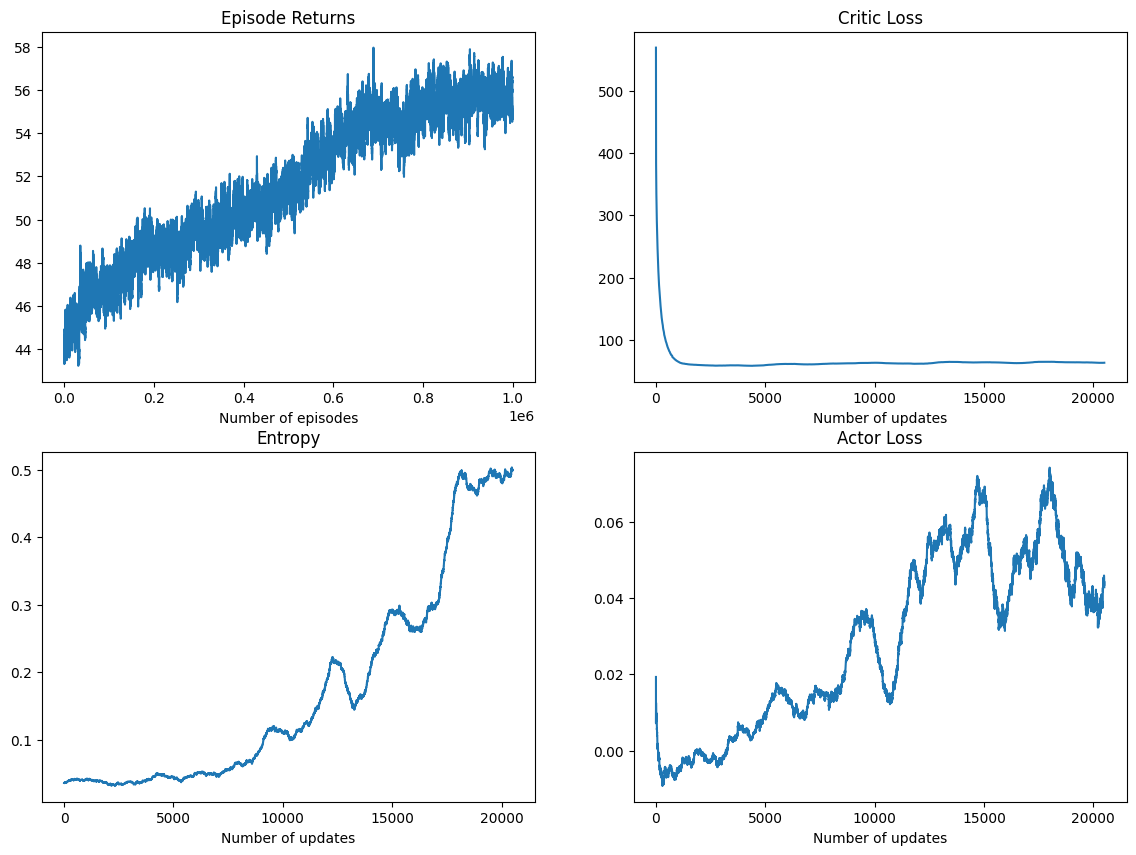

In [32]:
plot_results(dol_envs_wrapper,actor_losses,critic_losses,entropies,1000,)

In [13]:
torch.save(dol_agent.actor.state_dict(),'../model_weight/dolphin_a2c_v0_4.pkl')
torch.save(dol_agent.critic.state_dict(),'../model_weight/dolphin_a2c_critic_v0_4.pkl')

In [18]:
with open('../pickle_files/dol_a2c_1e6_part2_episode_return_loss_entropy','wb') as f:
    pickle.dump({'return':list(dol_envs_wrapper.return_queue),'actor':actor_losses,'critic':critic_losses,'entropy':entropies},f)